# Classification Model - XGBoost with Principal Components

In [79]:
#Importing all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from itertools import combinations
from scipy.stats import chi2_contingency
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV

In [80]:
print(os.getcwd())

c:\Users\ntama\Documentos\Data Science\Codecademy\projects\Date-A-Scientist - Final Project\OKCupid-Date-A-Scientist-Starter\date-a-scientist-project\notebooks


## Importing predictors and target - train, test and validation subsets

In [81]:
X_train = pd.read_csv("../data/X_train_pca.csv", index_col=False)
X_train = X_train.loc[:, ~X_train.columns.str.contains('^Unnamed')]

X_val = pd.read_csv("../data/X_val_pca.csv", index_col=False)
X_val = X_val.loc[:, ~X_val.columns.str.contains('^Unnamed')]

X_test = pd.read_csv("../data/X_test_pca.csv", index_col=False)
X_test = X_test.loc[:, ~X_test.columns.str.contains('^Unnamed')]

y_train = pd.read_csv("../data/y_train.csv", index_col=False)
y_train = y_train.loc[:, ~y_train.columns.str.contains('^Unnamed')]

y_val = pd.read_csv("../data/y_val.csv", index_col=False)
y_val = y_val.loc[:, ~y_val.columns.str.contains('^Unnamed')]

y_test = pd.read_csv("../data/y_test.csv", index_col=False)
y_test = y_test.loc[:, ~y_test.columns.str.contains('^Unnamed')]

These are the features with the most importance. They are being left as markdown in case it is necessary to drop them.

X_train = X_train.drop(['sex'], axis=1)
X_val = X_val.drop(['sex'], axis=1)
X_test = X_test.drop(['sex'], axis=1)

X_train = X_train.drop(['height'], axis=1)
X_val = X_val.drop(['height'], axis=1)
X_test = X_test.drop(['height'], axis=1)

X_train = X_train.drop(['age'], axis=1)
X_val = X_val.drop(['age'], axis=1)
X_test = X_test.drop(['age'], axis=1)

Checking data types for features in all three predictor sets

In [82]:
print(X_train.dtypes[X_train.dtypes == 'object']) 
print(X_val.dtypes[X_val.dtypes == 'object'])    
print(X_test.dtypes[X_test.dtypes == 'object'])   


Series([], dtype: object)
Series([], dtype: object)
Series([], dtype: object)


## Checking class imbalance

In [83]:
print(y_train.value_counts())

body_type
0            35519
1             6443
Name: count, dtype: int64


### RandomOverSampler on train set for class balance

In [84]:
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

### RandomUnderSampler on train set for class balance

In [85]:
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

## Model initialization

Calculating weights for each class 

In [86]:
# Making sure y_train and y_val is a series for calculating scale_pos_weight
if isinstance(y_train_res, pd.DataFrame):
    y_train_res = y_train_res.squeeze()

if isinstance(y_val, pd.DataFrame):
    y_val = y_val.squeeze()


# Ratios for imbalanced classes
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos


c:\Users\ntama\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


### Base model definition with basic parameters

In [87]:
model1 = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    #scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'
)

### Training the model with val set

In [88]:
model1.fit(
    X_train_under,
    y_train_under,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-logloss:0.66558
[1]	validation_0-logloss:0.65162
[2]	validation_0-logloss:0.64491
[3]	validation_0-logloss:0.64294
[4]	validation_0-logloss:0.64198
[5]	validation_0-logloss:0.64104
[6]	validation_0-logloss:0.64148
[7]	validation_0-logloss:0.64155
[8]	validation_0-logloss:0.64213
[9]	validation_0-logloss:0.64192


[10]	validation_0-logloss:0.64322
[11]	validation_0-logloss:0.64432
[12]	validation_0-logloss:0.64446
[13]	validation_0-logloss:0.64500
[14]	validation_0-logloss:0.64547
[15]	validation_0-logloss:0.64639
[16]	validation_0-logloss:0.64683
[17]	validation_0-logloss:0.64726
[18]	validation_0-logloss:0.64773
[19]	validation_0-logloss:0.64810
[20]	validation_0-logloss:0.64878
[21]	validation_0-logloss:0.64991
[22]	validation_0-logloss:0.65040
[23]	validation_0-logloss:0.65138
[24]	validation_0-logloss:0.65189
[25]	validation_0-logloss:0.65221
[26]	validation_0-logloss:0.65287
[27]	validation_0-logloss:0.65348
[28]	validation_0-logloss:0.65386
[29]	validation_0-logloss:0.65469
[30]	validation_0-logloss:0.65575
[31]	validation_0-logloss:0.65623
[32]	validation_0-logloss:0.65635
[33]	validation_0-logloss:0.65702
[34]	validation_0-logloss:0.65790
[35]	validation_0-logloss:0.65800
[36]	validation_0-logloss:0.65812
[37]	validation_0-logloss:0.65915
[38]	validation_0-logloss:0.66000
[39]	validatio

c:\Users\ntama\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:46:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[54]	validation_0-logloss:0.66731
[55]	validation_0-logloss:0.66820
[56]	validation_0-logloss:0.66877
[57]	validation_0-logloss:0.66955
[58]	validation_0-logloss:0.66945
[59]	validation_0-logloss:0.67069
[60]	validation_0-logloss:0.67134
[61]	validation_0-logloss:0.67208
[62]	validation_0-logloss:0.67273
[63]	validation_0-logloss:0.67286
[64]	validation_0-logloss:0.67306
[65]	validation_0-logloss:0.67364
[66]	validation_0-logloss:0.67407
[67]	validation_0-logloss:0.67434
[68]	validation_0-logloss:0.67500
[69]	validation_0-logloss:0.67534
[70]	validation_0-logloss:0.67591
[71]	validation_0-logloss:0.67633
[72]	validation_0-logloss:0.67754
[73]	validation_0-logloss:0.67800
[74]	validation_0-logloss:0.67791
[75]	validation_0-logloss:0.67857
[76]	validation_0-logloss:0.67914
[77]	validation_0-logloss:0.67939
[78]	validation_0-logloss:0.67984
[79]	validation_0-logloss:0.68012
[80]	validation_0-logloss:0.68053
[81]	validation_0-logloss:0.68113
[82]	validation_0-logloss:0.68126
[83]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

### Predictions and metrics report

In [89]:
y_val_pred = model1.predict(X_val)

# Metric report
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.91      0.60      0.72      7611
           1       0.23      0.66      0.34      1381

    accuracy                           0.61      8992
   macro avg       0.57      0.63      0.53      8992
weighted avg       0.80      0.61      0.66      8992

[[4535 3076]
 [ 471  910]]


### Showing feature importance

In [90]:
print(X_train.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')


In [91]:
model1.feature_importances_

array([0.1512629 , 0.06000509, 0.08379842, 0.07553384, 0.05985773,
       0.06677991, 0.07281083, 0.07792148, 0.21582846, 0.06527629,
       0.07092505], dtype=float32)

### Hyperparameter tuning with GridSearchCV
Focusing on high recall

In [92]:
model2 = XGBClassifier(
    objective='binary:logistic',
    #scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss',
    n_estimators=200,
    learning_rate=0.1,
    max_depth= 4,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1
)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.2]
}

grid_search = GridSearchCV(
    estimator=model2,
    param_grid=param_grid,
    scoring='recall',
    cv=3
)


grid_search.fit(X_train_res, y_train_res)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=0.1,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=...
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=-1, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.2],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'min_child_weight': [1, 3], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='recall')

In [93]:
best_model = grid_search.best_estimator_

y_val_pred = best_model.predict(X_val)

print("Best hyperparameters: ", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
print("\nConfusion Matrix")
print(confusion_matrix(y_val, y_val_pred))

Best hyperparameters:  {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      7611
           1       0.25      0.65      0.36      1381

    accuracy                           0.65      8992
   macro avg       0.58      0.65      0.56      8992
weighted avg       0.81      0.65      0.70      8992


Confusion Matrix
[[4914 2697]
 [ 481  900]]


The model is having a good recall balance, meaning a good detection of both classes, but sacrifiying precision in the minoritarian class (many false positives)

In [94]:
y_val_predict_prob = best_model.predict_proba(X_val)[:,1]

thresh = np.linspace(0.1, 0.9, 20)
false_negatives = []
recall = []
precision = []
f1 = []

for t in thresh:
    y_val_pred = (y_val_predict_prob >= t).astype(int)
    cm = confusion_matrix(y_val, y_val_pred)
    fn = cm[1, 0]
    false_negatives.append(fn)
    rs = recall_score(y_val, y_val_pred)
    recall.append(rs)
    ps = precision_score(y_val, y_val_pred)
    precision.append(ps)
    fs = f1_score(y_val, y_val_pred)
    f1.append(fs)



c:\Users\ntama\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [95]:
print(recall)

[0.997103548153512, 0.9862418537291817, 0.9703113685734974, 0.939898624185373, 0.8935553946415641, 0.837074583635047, 0.7965242577842143, 0.7516292541636496, 0.721940622737147, 0.6784938450398262, 0.6270818247646633, 0.5691527878349022, 0.4525706010137581, 0.30847212165097754, 0.15858073859522084, 0.09268645908761766, 0.0391020999275887, 0.013758146270818247, 0.002896451846488052, 0.0]


### Threshold vs Recall

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


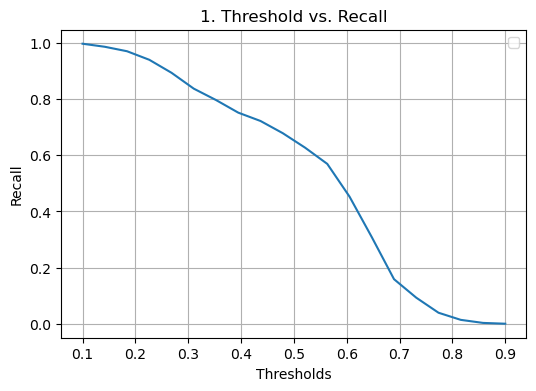

In [96]:
plt.figure(figsize=(6, 4))
plt.plot(thresh, recall)
plt.xlabel("Thresholds")
plt.ylabel("Recall")
plt.title("1. Threshold vs. Recall")
plt.legend()
plt.grid()
plt.show()

### Threshold vs Precision

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


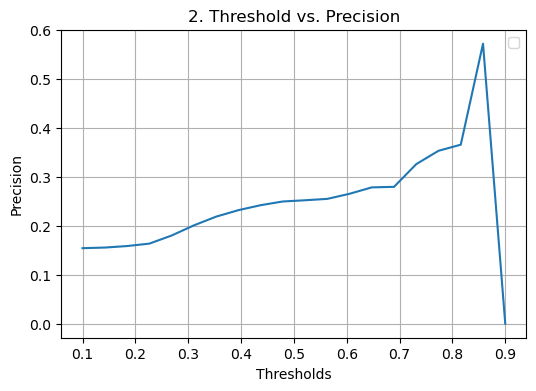

In [97]:
plt.figure(figsize=(6, 4))
plt.plot(thresh, precision)
plt.xlabel("Thresholds")
plt.ylabel("Precision")
plt.title("2. Threshold vs. Precision")
plt.legend()
plt.grid()
plt.show()

### ROC / AUC

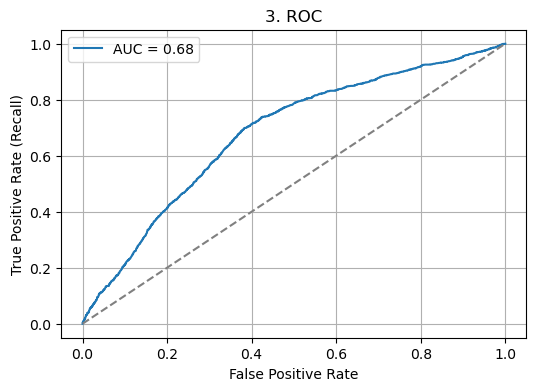

In [98]:
#CURVA ROC + AUC
fpr, tpr, thresholds_roc = roc_curve(y_val, y_val_predict_prob)
auc_score = roc_auc_score(y_val, y_val_predict_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("3. ROC")
plt.legend()
plt.grid()
plt.show()

### Threshold vs F1 Score

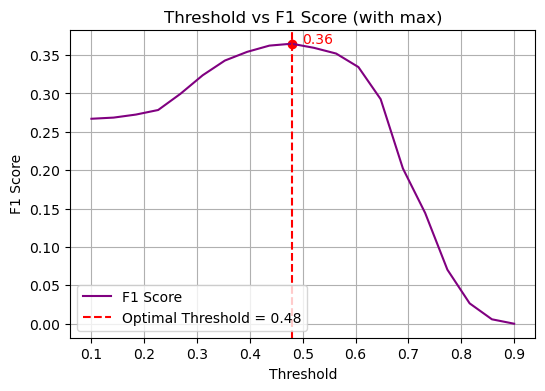

In [99]:
idx_max = np.argmax(f1)
thresh_max = thresh[idx_max]
f1_max = f1[idx_max]

plt.figure(figsize=(6, 4))
plt.plot(thresh, f1, label="F1 Score", color='purple')
plt.axvline(x=thresh_max, color='red', linestyle='--', label=f'Optimal Threshold = {thresh_max:.2f}')
plt.scatter([thresh_max], [f1_max], color='red')
plt.text(thresh_max + 0.02, f1_max, f"{f1_max:.2f}", color='red')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold vs F1 Score (with max)")
plt.legend()
plt.grid()
plt.show()

## Final Evaluation: Running the model on test set with chosen hyperparameters and threshold 

Best hyperparameters:  {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}

In [100]:
model_final = XGBClassifier(
    objective='binary:logistic',
    #scale_pos_weight=scale_pos_weight,
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss',
    n_estimators=200,
    learning_rate=0.1,
    max_depth= 5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=1.0,
    gamma=0.2
)

In [101]:
model_final.fit(
    X_train_under,
    y_train_under,
    eval_set=[(X_test, y_test)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

In [111]:
y_test_pred = model_final.predict(X_test)
y_test_pred_prob = model_final.predict_proba(X_test)
y_test_pred_class = (y_test_pred_prob[:,1] > 0.48)

y_train_pred = model_final.predict(X_train)
y_train_pred_prob = model_final.predict_proba(X_train)
y_train_pred_class = (y_train_pred_prob[:,1] > 0.48)

# Metric report
print(classification_report(y_test, y_test_pred_class))
print(confusion_matrix(y_test, y_test_pred_class))

              precision    recall  f1-score   support

           0       0.91      0.59      0.72      7611
           1       0.23      0.69      0.35      1381

    accuracy                           0.61      8992
   macro avg       0.57      0.64      0.53      8992
weighted avg       0.81      0.61      0.66      8992

[[4515 3096]
 [ 435  946]]
